In [1]:
from cmdstanpy import CmdStanModel

modelcode = """
data {
    int<lower = 1> reps; // replicates
    int<lower = 0> counts[reps, 4]; // we're only using the count data up to 4
}

parameters {
    real<lower = 0, upper = 1> p[reps]; // probability of a monomer being fluorescent
    real<lower = 0, upper = 1> frac_tetramer[reps]; // assuming only dimer and tetramer populations
    real<lower = 0> p_alpha; // beta parameters defining the degree of pooling between replicates
    real<lower = 0> p_beta;
    real<lower = 0> frac_alpha;
    real<lower = 0> frac_beta;
}

model {
    // instead of specifying a prior for alpha and beta individually, we will specify a prior for the inverse var
    (square(p_alpha + p_beta) * (p_alpha + p_beta + 1)) / p_alpha * p_beta ~ exponential(1e-7);
    (square(frac_alpha + frac_beta) * (frac_alpha + frac_beta + 1)) / frac_alpha * frac_beta ~ exponential(1e-7);
    p ~ beta(p_alpha, p_beta);
    frac_tetramer ~ beta(frac_alpha, frac_beta);
    // our binomial mixture of n = 4 and n = 2:
    for (i in 1:reps) {
        target += counts[i, 1] * log_mix(frac_tetramer[i],
                                         binomial_lpmf(1 | 4, p[i]) - binomial_lccdf(0 | 4, p[i]),
                                         binomial_lpmf(1 | 2, p[i]) - binomial_lccdf(0 | 2, p[i]));
        target += counts[i, 2] * log_mix(frac_tetramer[i],
                                         binomial_lpmf(2 | 4, p[i]) - binomial_lccdf(0 | 4, p[i]),
                                         binomial_lpmf(2 | 2, p[i]) - binomial_lccdf(0 | 2, p[i]));
        target += counts[i, 3] * (log(frac_tetramer[i]) +
                  binomial_lpmf(3 | 4, p[i]) - binomial_lccdf(0 | 4, p[i]));
        target += counts[i, 4] * (log(frac_tetramer[i]) +
                  binomial_lpmf(4 | 4, p[i]) - binomial_lccdf(0 | 4, p[i]));
    } // subtracting the log complementary CDF accounts for the 0 population being censored
}

generated quantities {
    
}
"""

filename = "park-2020.stan"

with open(filename, 'w') as f:
    f.write(modelcode)

model = CmdStanModel(stan_file = filename)
model.compile()

INFO:cmdstanpy:compiling stan program, exe file: /home/kent/park-2020
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/kent/park-2020
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/kent/park-2020


In [2]:
import numpy as np

# Make a NumPy array to hold the data with dimensions (conditions, replicates, counts)
data = np.empty((5, 3, 7), dtype = int)

with open("park-2020_fig-1_data.csv", 'r') as f:
    for line in f.readlines()[1:]:
        fields = [int(field) for field in line.rstrip().split(',')]
        data[fields[0] - 1, fields[1] - 1, fields[2] - 1] = fields[3]
        
print(data)

[[[23 65 29 36  3  5  5]
  [16 66 29 39  8  3  4]
  [26 64 29 44  3  3  4]]

 [[10 31 45 61  5  3  2]
  [ 9 36 46 60  6  3  1]
  [12 29 43 65  5  5  1]]

 [[23 69 34 46  4  5  4]
  [30 76 36 50  2  3  7]
  [15 65 30 50  5  2  8]]

 [[15 36 46 70  3  4  3]
  [ 9 33 44 63  8  5  3]
  [19 45 56 78  5  5  5]]

 [[ 5 16 23 39  3  4  3]
  [ 6 23 34 51  9  4  8]
  [16 45 60 83  5  6  3]]]


In [3]:
conditions = [{"reps": 3, "counts": data[i, :, :4]} for i in range(5)]
inits = {"p": [0.9, 0.9, 0.9], "frac_tetramer": [0.5, 0.5, 0.5],
         "p_alpha": 1, "p_beta": 1, "frac_alpha": 1, "frac_beta": 1}
fits = []

for i in range(5):
    fits.append(model.sample(conditions[i], inits = inits, iter_sampling = 10000))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

Mean fraction tetramer (94% credible interval):
0: 0.50 (0.43-0.58)
1: 0.81 (0.75-0.88)
2: 0.53 (0.46-0.60)
3: 0.78 (0.72-0.85)
4: 0.81 (0.75-0.88)


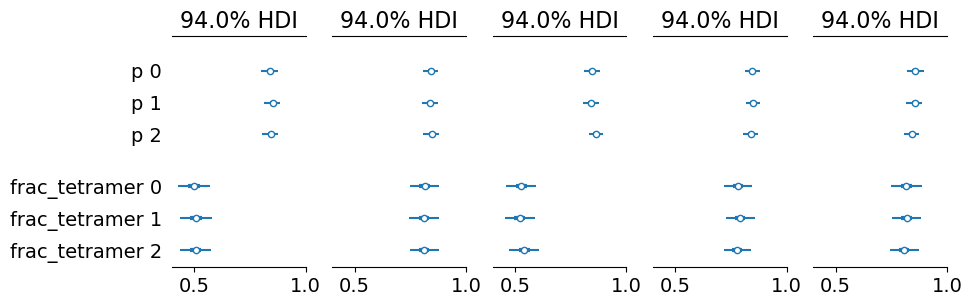

In [4]:
import arviz as az
from matplotlib import pyplot as plt

az.style.use("default") # default matplotlib style

data = [az.from_cmdstanpy(posterior = fit) for fit in fits]
f, axes = plt.subplots(1, 5, sharey = True, figsize = (10,3))
print("Mean fraction tetramer (94% credible interval):")
for i in range(5):
    az.plot_forest(data[i], var_names = ["p", "frac_tetramer"], combined = True, ax = axes[i])
    axes[i].set_xlim(0.4, 1)
    print(str(i) + ": " +
          format(np.mean(data[i].posterior.frac_tetramer.data.flatten()), ".2f") + " (" +
          format(np.quantile(data[i].posterior.frac_tetramer.data.flatten(), 0.03), ".2f") + "-" +
          format(np.quantile(data[i].posterior.frac_tetramer.data.flatten(), 0.97), ".2f") + ")")
plt.show()

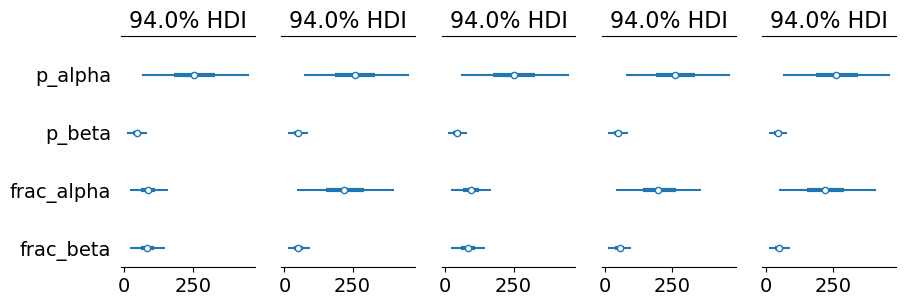

In [5]:
f, axes = plt.subplots(1, 5, sharey = True, figsize = (10,3))
for i in range(5):
    az.plot_forest(data[i], var_names = ["p_alpha", "p_beta", "frac_alpha", "frac_beta"], combined = True, ax = axes[i])
plt.show()

Text(0, 0.5, 'frequency')

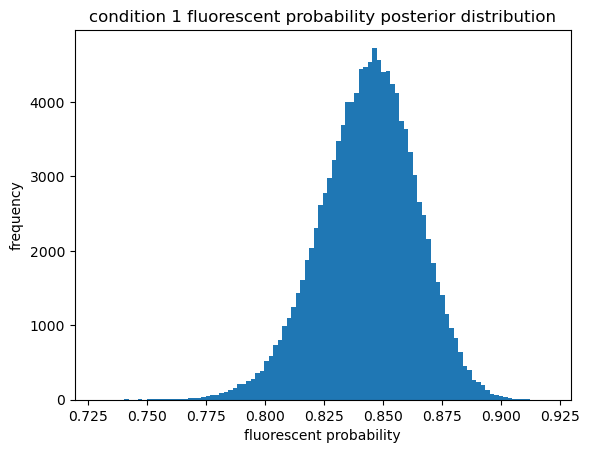

In [6]:
plt.hist(data[0].posterior.p.data.flatten(), bins = 100)
plt.title("condition 1 fluorescent probability posterior distribution")
plt.xlabel("fluorescent probability")
plt.ylabel("frequency")
# compare to:
# plt.hist(np.random.beta(data[0].posterior.p_alpha.data.flatten(), data[0].posterior.p_beta.data.flatten()), bins = 100)

Text(0, 0.5, 'frequency')

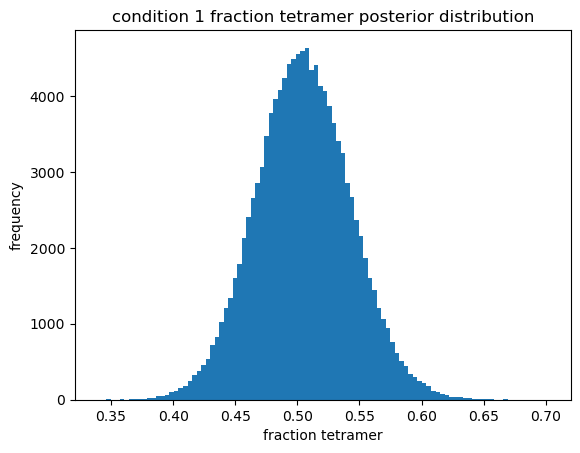

In [7]:
plt.hist(data[0].posterior.frac_tetramer.data.flatten(), bins = 100)
plt.title("condition 1 fraction tetramer posterior distribution")
plt.xlabel("fraction tetramer")
plt.ylabel("frequency")
# compare to:
# plt.hist(np.random.beta(data[0].posterior.frac_alpha.data.flatten(), data[0].posterior.frac_beta.data.flatten()), bins = 100)

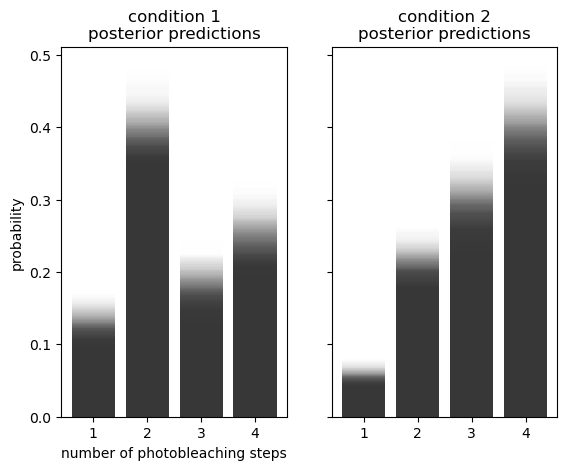

In [8]:
from scipy.stats import binom

x = np.arange(1, 5)

f, axes = plt.subplots(1, 2, sharey = True)
for i in range(0, 40000, 200):
    p_1 = data[0].posterior.p.data.flatten()[i]
    p_2 = data[1].posterior.p.data.flatten()[i]
    frac_1 = data[0].posterior.frac_tetramer.data.flatten()[i]
    frac_2 = data[1].posterior.frac_tetramer.data.flatten()[i]
    axes[0].bar(x, frac_1 * binom.pmf(x, 4, p_1) + (1 - frac_1) * binom.pmf(x, 2, p_1), alpha = 1 / 200, color = 'black')
    axes[1].bar(x, frac_2 * binom.pmf(x, 4, p_2) + (1 - frac_2) * binom.pmf(x, 2, p_2), alpha = 1 / 200, color = 'black')
axes[0].set_title("condition 1\nposterior predictions")
axes[1].set_title("condition 2\nposterior predictions")
axes[0].set_xlabel("number of photobleaching steps")
axes[0].set_ylabel("probability")
plt.show()

In [9]:
from cmdstanpy import CmdStanModel

modelcode = """
data {
    int<lower = 1> reps; // replicates
    int<lower = 0> counts[reps, 4]; // we're only using the count data up to 4
}

parameters {
    real<lower = 0, upper = 1> p[reps]; // probability of a monomer being fluorescent
    real<lower = 0, upper = 1> frac_tetramer[reps]; // assuming only dimer and tetramer populations
}

model {
    p ~ beta(1, 1); // no pooling, uninformative prior on p and frac_tetramer
    frac_tetramer ~ beta(1, 1);
    // our binomial mixture of n = 4 and n = 2:
    for (i in 1:reps) {
        target += counts[i, 1] * log_mix(frac_tetramer[i],
                                         binomial_lpmf(1 | 4, p[i]) - binomial_lccdf(0 | 4, p[i]),
                                         binomial_lpmf(1 | 2, p[i]) - binomial_lccdf(0 | 2, p[i]));
        target += counts[i, 2] * log_mix(frac_tetramer[i],
                                         binomial_lpmf(2 | 4, p[i]) - binomial_lccdf(0 | 4, p[i]),
                                         binomial_lpmf(2 | 2, p[i]) - binomial_lccdf(0 | 2, p[i]));
        target += counts[i, 3] * (log(frac_tetramer[i]) +
                  binomial_lpmf(3 | 4, p[i]) - binomial_lccdf(0 | 4, p[i]));
        target += counts[i, 4] * (log(frac_tetramer[i]) +
                  binomial_lpmf(4 | 4, p[i]) - binomial_lccdf(0 | 4, p[i]));
    } // subtracting the log complementary CDF accounts for the 0 population being censored
}

generated quantities {
    
}
"""

filename = "park-2020_no-pooling.stan"

with open(filename, 'w') as f:
    f.write(modelcode)

model_nopooling = CmdStanModel(stan_file = filename)
model_nopooling.compile()

INFO:cmdstanpy:compiling stan program, exe file: /home/kent/park-2020_no-pooling
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/kent/park-2020_no-pooling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/kent/park-2020_no-pooling


In [10]:
inits = {"p": [0.9, 0.9, 0.9], "frac_tetramer": [0.5, 0.5, 0.5]}
fits_nopooling = []

for i in range(5):
    fits_nopooling.append(model_nopooling.sample(conditions[i], inits = inits, iter_sampling = 10000))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

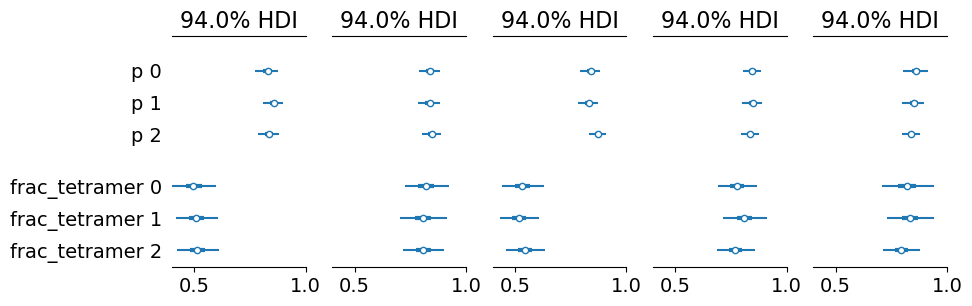

In [11]:
data_nopooling = [az.from_cmdstanpy(posterior = fit) for fit in fits_nopooling]
f, axes = plt.subplots(1, 5, sharey = True, figsize = (10,3))
for i in range(5):
    az.plot_forest(data_nopooling[i], var_names = ["p", "frac_tetramer"], combined = True, ax = axes[i])
    axes[i].set_xlim(0.4,1)
plt.show()

Text(0.5, 1.0, 'posterior distributions for condition 1 without pooling between replicates')

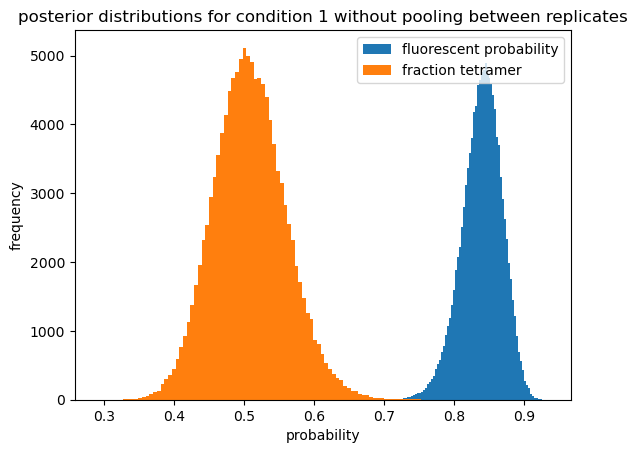

In [12]:
plt.hist(data_nopooling[0].posterior.p.data.flatten(), bins = 100)
plt.hist(data_nopooling[0].posterior.frac_tetramer.data.flatten(), bins = 100)
plt.legend(["fluorescent probability", "fraction tetramer"])
plt.xlabel("probability")
plt.ylabel("frequency")
plt.title("posterior distributions for condition 1 without pooling between replicates")